# Final Project Report
##### *Cynthia Wang, Luke Angelo Santiago, Tim Generalov, Sarah Porcheron*

## Introduction

In the realm of video game analytics, understanding player behavior is crucial for enhancing user engagement and optimizing marketing strategies. For this analysis, we focus specifically on the Minecraft research project, tailoring our findings to provide actionable insights for this initiative. Our goal is to identify **which "kinds" of players are most likely to contribute significant amounts of data**, enabling the project to target these players in future recruiting efforts effectively.

To address this question, we utilized the player dataset, which includes various characteristics and metrics related to Minecraft players. This dataset serves as the foundation for exploring trends, behaviors, and contributions of players. By examining this information, we aim to deliver targeted recommendations for the Minecraft research project, ensuring that our analysis is highly relevant and actionable for their specific needs.



#### Dataset Description

The analysis is mainly based on the following dataset:

 **Players Dataset (`players.csv`):** This dataset contains demographic and player profile information, such as age, gender, geographical location, and in-game roles or preferences.


By utilizing the player dataset, we aim to establish a comprehensive profile of highly engaged players. The datasets were meticulously prepared to ensure no missing values or inconsistencies that could bias the results. The Players dataset provides demographic attributes, offering a well-rounded foundation for analysis.

#### Goal of the Analysis

The primary goal is to identify which player characteristics correlate with the amount of gameplay data contributed. For instance:
- Are younger players more engaged than older ones?
- Do players with certain in-game roles or preferences exhibit higher activity levels?
- How do session durations and frequencies relate to demographic factors?

The findings of this analysis will provide actionable insights for recruiting and engaging with high-value players, ultimately supporting the strategic goals of player retention and monetization.



## Methods

Intro: We need to indentify the types of players that are most likely to contribute significant amounts of game data, to start this we will - 

1. Load all data 
- Load using read.csv (since data is comma seperated), and to make this process reproducible on all devices we will load the data from a url (original data is from a google drive link)

2. Preprocess data
- Columns such as "experience" and "gender" need to be converted into factor types to make sure they are treated as categorical variables for analysis
- Columns that we don't need to answer our question such as "hashedEmail" (empty), "individualId" (empty), "organizationName" (empty), "subscribe" (not needed), and "name" (not needed) will be removed.
- Double check columns: "experience" (categorical), "played_hours" (numeric), "gender" (categorical) and "age" (numeric) should all be present in the data set as we need them for our analysis

3. Exploratory data analysis
- Use group_by and summarize to sort the number of players by experience level as wel as gender
- Plot this information using geom_histogram to show the number of hours played across experience, seperated by gender to see if it also contributes to the number of hours played
- Filter age below 51 to focus on the majority demographic of users, calculate average hours played for each age and experience combination, and create a geom_bar plot with a facet grid based on experience to show any trends in hours played across age groups
- Summarize counts by gender and experience, and visualize using geom_bar with position = "fill" to show gender makeup of each experience group
- Use geom_histogram to visualize overall distribution of played hours

4. Do predictive modeling: regression on played hours
- Split the dataset into training (70%) and testing (30%) using initial_split and stratified by played_hours to have a proportional distribution across splits
- Create a recipe using the recipe function, and specify played_hours as the response variable and all other columns as predictors
- Use k-Nearest Neighbors algorithm for regression with nearest_neighbors function. We use this algorithm because of its ability to capture non-linear patterns, handle different data types and make predictions based on similar players 
- Perform 15 fold cross validation to evaluate the performance as best as possible and avoid any possible outlier splits
- Tune the number of neighbors using grid search with values ranging from 1 to 100 in order to balance out overfitting and underfitting
- Select optimal k number of neighbors based on root mean square error (RMSE) to have the best prediction accuracy
- Re-train the k-NN model using optimal k value and evaluate performance on the test set by getting RMSE for predictions

5. Visualize results
- Plot relationship betwen k number of neighbors and RMSE to visualize the tunning process (optimal k value minimized RMSE)
- Combine key visualization into grids using plot_grid to visualize all variables and their effect on played_hours: Hours played by experience and gender plot, age trends in hours played, and gender makeup in experience groups

Taking a look at the final visualization plot grid will show how age, gender, experience level will affect the amount of time a user spends on the game, at which point we will be able to draw conclusions from the data and answer our question.

## Results

In [64]:
install.packages("GGally")

Warning message:
"package 'GGally' is in use and will not be installed"


In [65]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(GGally)
library(tidymodels)
library(cowplot)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

### Code

In [66]:
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players <- 
    # read_csv(url) |>
     read_csv("data/players.csv") |>
    # experience and gender changed to factor type in order to be treated as category
    mutate(experience = as.factor(experience),
           gender = as.factor(gender)) |>

    # removed hashedEmail, individualId, and organizationName because they have no information
    # removed subscribe and name because they have no useful information about the type of user
    select(experience, played_hours, gender, age)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Explatory Code

In [67]:
# number of players in each experience level
num_players_by_exp <- players |>
    group_by(experience) |>
    summarize(count = n()) |>
    arrange(count)

In [68]:
# number of players from a certain gender
num_players_by_gender <- players |>
    group_by(gender) |>
    summarize(count = n()) |>
    arrange(count)

In [69]:
# hours contributed by experience level and gender
experience_vs_hours <- players |>
    ggplot(aes(x = experience, y = played_hours, fill = gender)) +
    geom_histogram(stat = "identity", position = "dodge") +
    labs(x = "Experience",
         y = "# of hours played",
         title = "Hours Contribution by Experience and Gender") +
    theme(text = element_text(size = 15)) +
    scale_fill_brewer(palette = 'Set2')

Warning message in geom_histogram(stat = "identity", position = "dodge"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


In [70]:
# each experience level group's mean hours based on age
players_bar <- players |>
    filter(age < 51) |>
    group_by(age, experience) |>
    summarize(avg_played_hours = mean(played_hours)) |>
    ggplot(aes(x = age, y = avg_played_hours, fill = experience)) +
    geom_bar(stat = "identity") +
    facet_grid(rows = vars(experience)) +
    labs(x = "Age",
         y = "Average hours played",
         fill = "Experience level",
         title = "Mean Playing Hours Compared to Age and Experience") +
    theme(text = element_text(size = 15)) +
    scale_fill_brewer(palette = 'Paired')

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


In [71]:
# distribution of played hours
played_hours <- ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 5, fill = "steelblue", color = "black") +
  labs(title = "Distribution of Total Played Hours",
       x = "Total Played Hours",
       y = "Number of Players") +
  theme(text = element_text(size = 15))


In [72]:
# graph comparing the gender make-up in each experience level group
gender_makeup <- players |>
    group_by(gender, experience) |>
    summarize(count = n()) |>
    ggplot(aes(x = count, y = experience, fill = gender)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "Gender make-up (%)",
         y = "Experience",
         title = "Gender Make-up of Experience Level Groups") +
    theme(text = element_text(size = 15)) +
    scale_fill_brewer(palette = 'Set2')

`summarise()` has grouped output by 'gender'. You can override using the
`.groups` argument.


#### Classification Model Code

In [73]:
set.seed(170) # DO NOT REMOVE

# splitting the data 
players_split <- initial_split(players, prop = 0.7, strata = played_hours)
players_train <- training(players_split) # 136 observations
players_test <- testing(players_split) # 60 observations

In [74]:
set.seed(6330) # DO NOT REMOVE

# training the data
players_recipe <- recipe(played_hours ~ ., data = players)

players_spec <- nearest_neighbor(weight_func = "rectangular",
                                 neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_train, v = 15, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1)) 

players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

kmin <- players_results |>
    filter(mean == min(mean)) |>
    pull(neighbors)

In [75]:
# testing the data
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

players_summary <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test) |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == 'rmse')

### Explatory Graphs

experience,played_hours,gender,age
<fct>,<dbl>,<fct>,<dbl>
Pro,30.3,Male,9
Veteran,3.8,Male,17
Veteran,0.0,Male,17
⋮,⋮,⋮,⋮
Amateur,0.0,Prefer not to say,17
Amateur,2.3,Male,17
Pro,0.2,Other,91


experience,count
<fct>,<int>
Pro,14
Beginner,35
Regular,36
Veteran,48
Amateur,63


gender,count
<fct>,<int>
Other,1
Agender,2
Two-Spirited,6
⋮,⋮
Non-binary,15
Female,37
Male,124


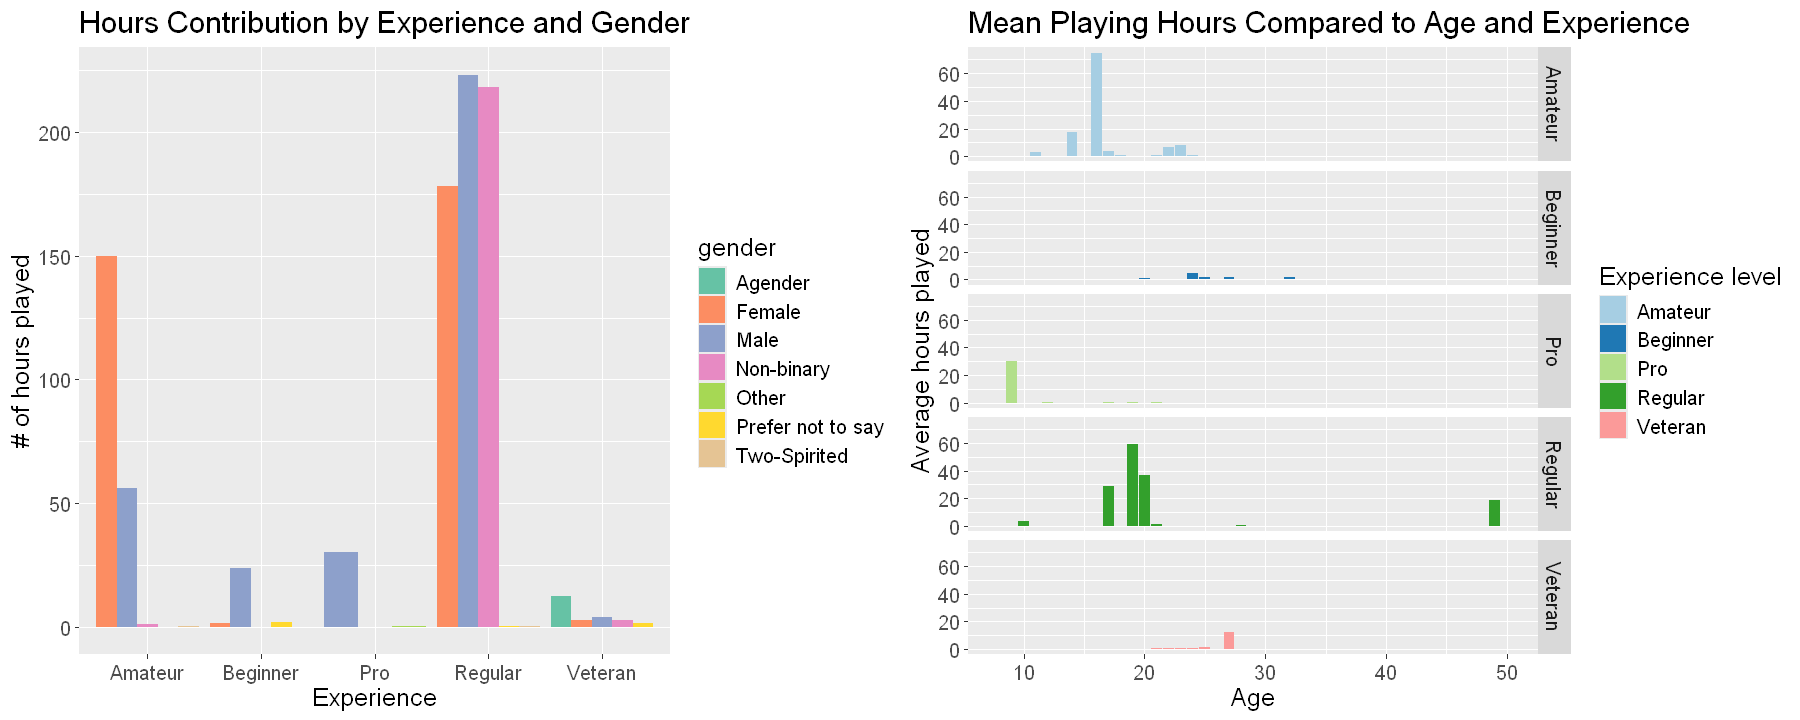

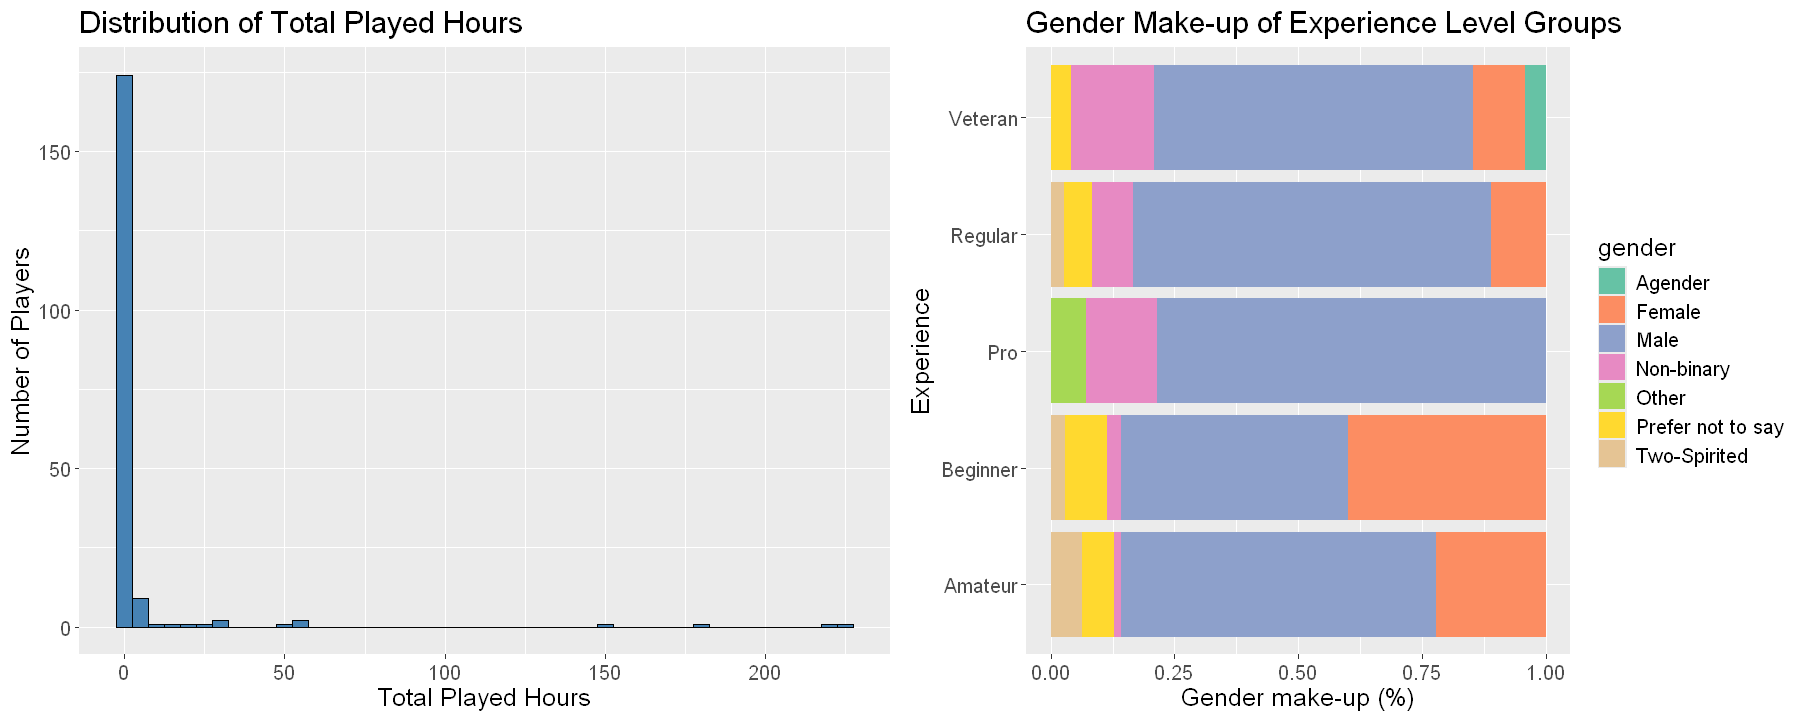

In [76]:
players
num_players_by_exp
num_players_by_gender

options(repr.plot.width = 15, repr.plot.height = 6)

plot_grid(experience_vs_hours, players_bar,
          ncol = 2)

options(repr.plot.width = 15, repr.plot.height = 6)

plot_grid(played_hours, gender_makeup,
          ncol = 2)

#### Classification Graphs

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,19.75187,15,7.084962,Preprocessor1_Model001
2,rmse,standard,17.08186,15,6.291527,Preprocessor1_Model002
3,rmse,standard,18.96664,15,6.153587,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
98,rmse,standard,16.07385,15,5.882626,Preprocessor1_Model098
99,rmse,standard,16.04970,15,5.880224,Preprocessor1_Model099
100,rmse,standard,16.07419,15,5.877940,Preprocessor1_Model100


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
55,rmse,standard,15.72185,15,5.948321,Preprocessor1_Model055


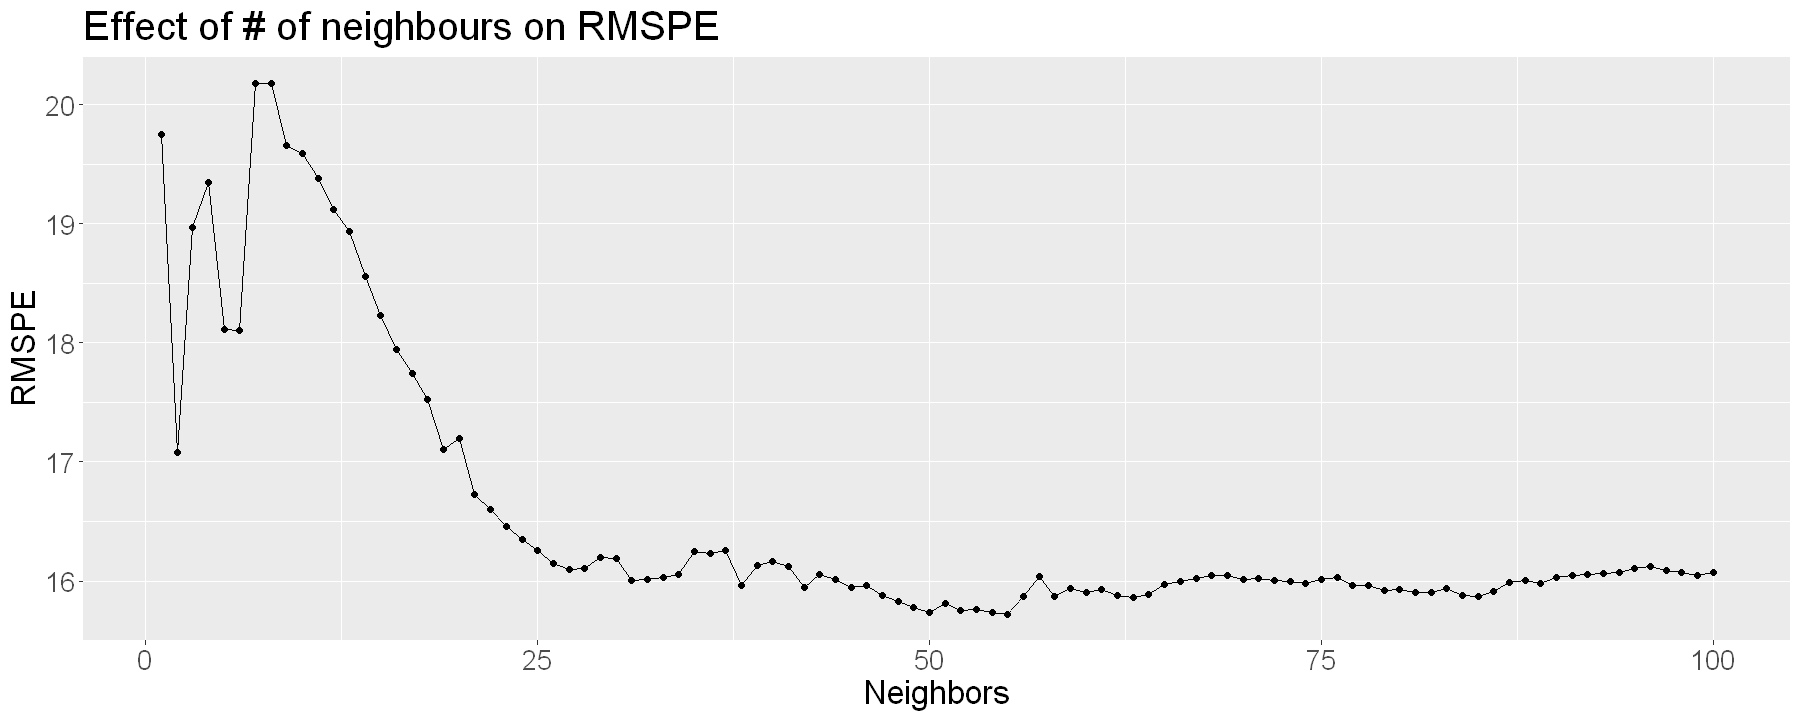

In [77]:
# displays results of training to find the best k value

players_results

players_results |>
filter(mean == min(mean))

ggplot(players_results, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors",
     y = "RMSPE",
     title = "Effect of # of neighbours on RMSPE") +

theme(text = element_text(size = 20))

In [78]:
# displays the RMSPE of the data at the best k value (k = 55)
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,30.2893


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


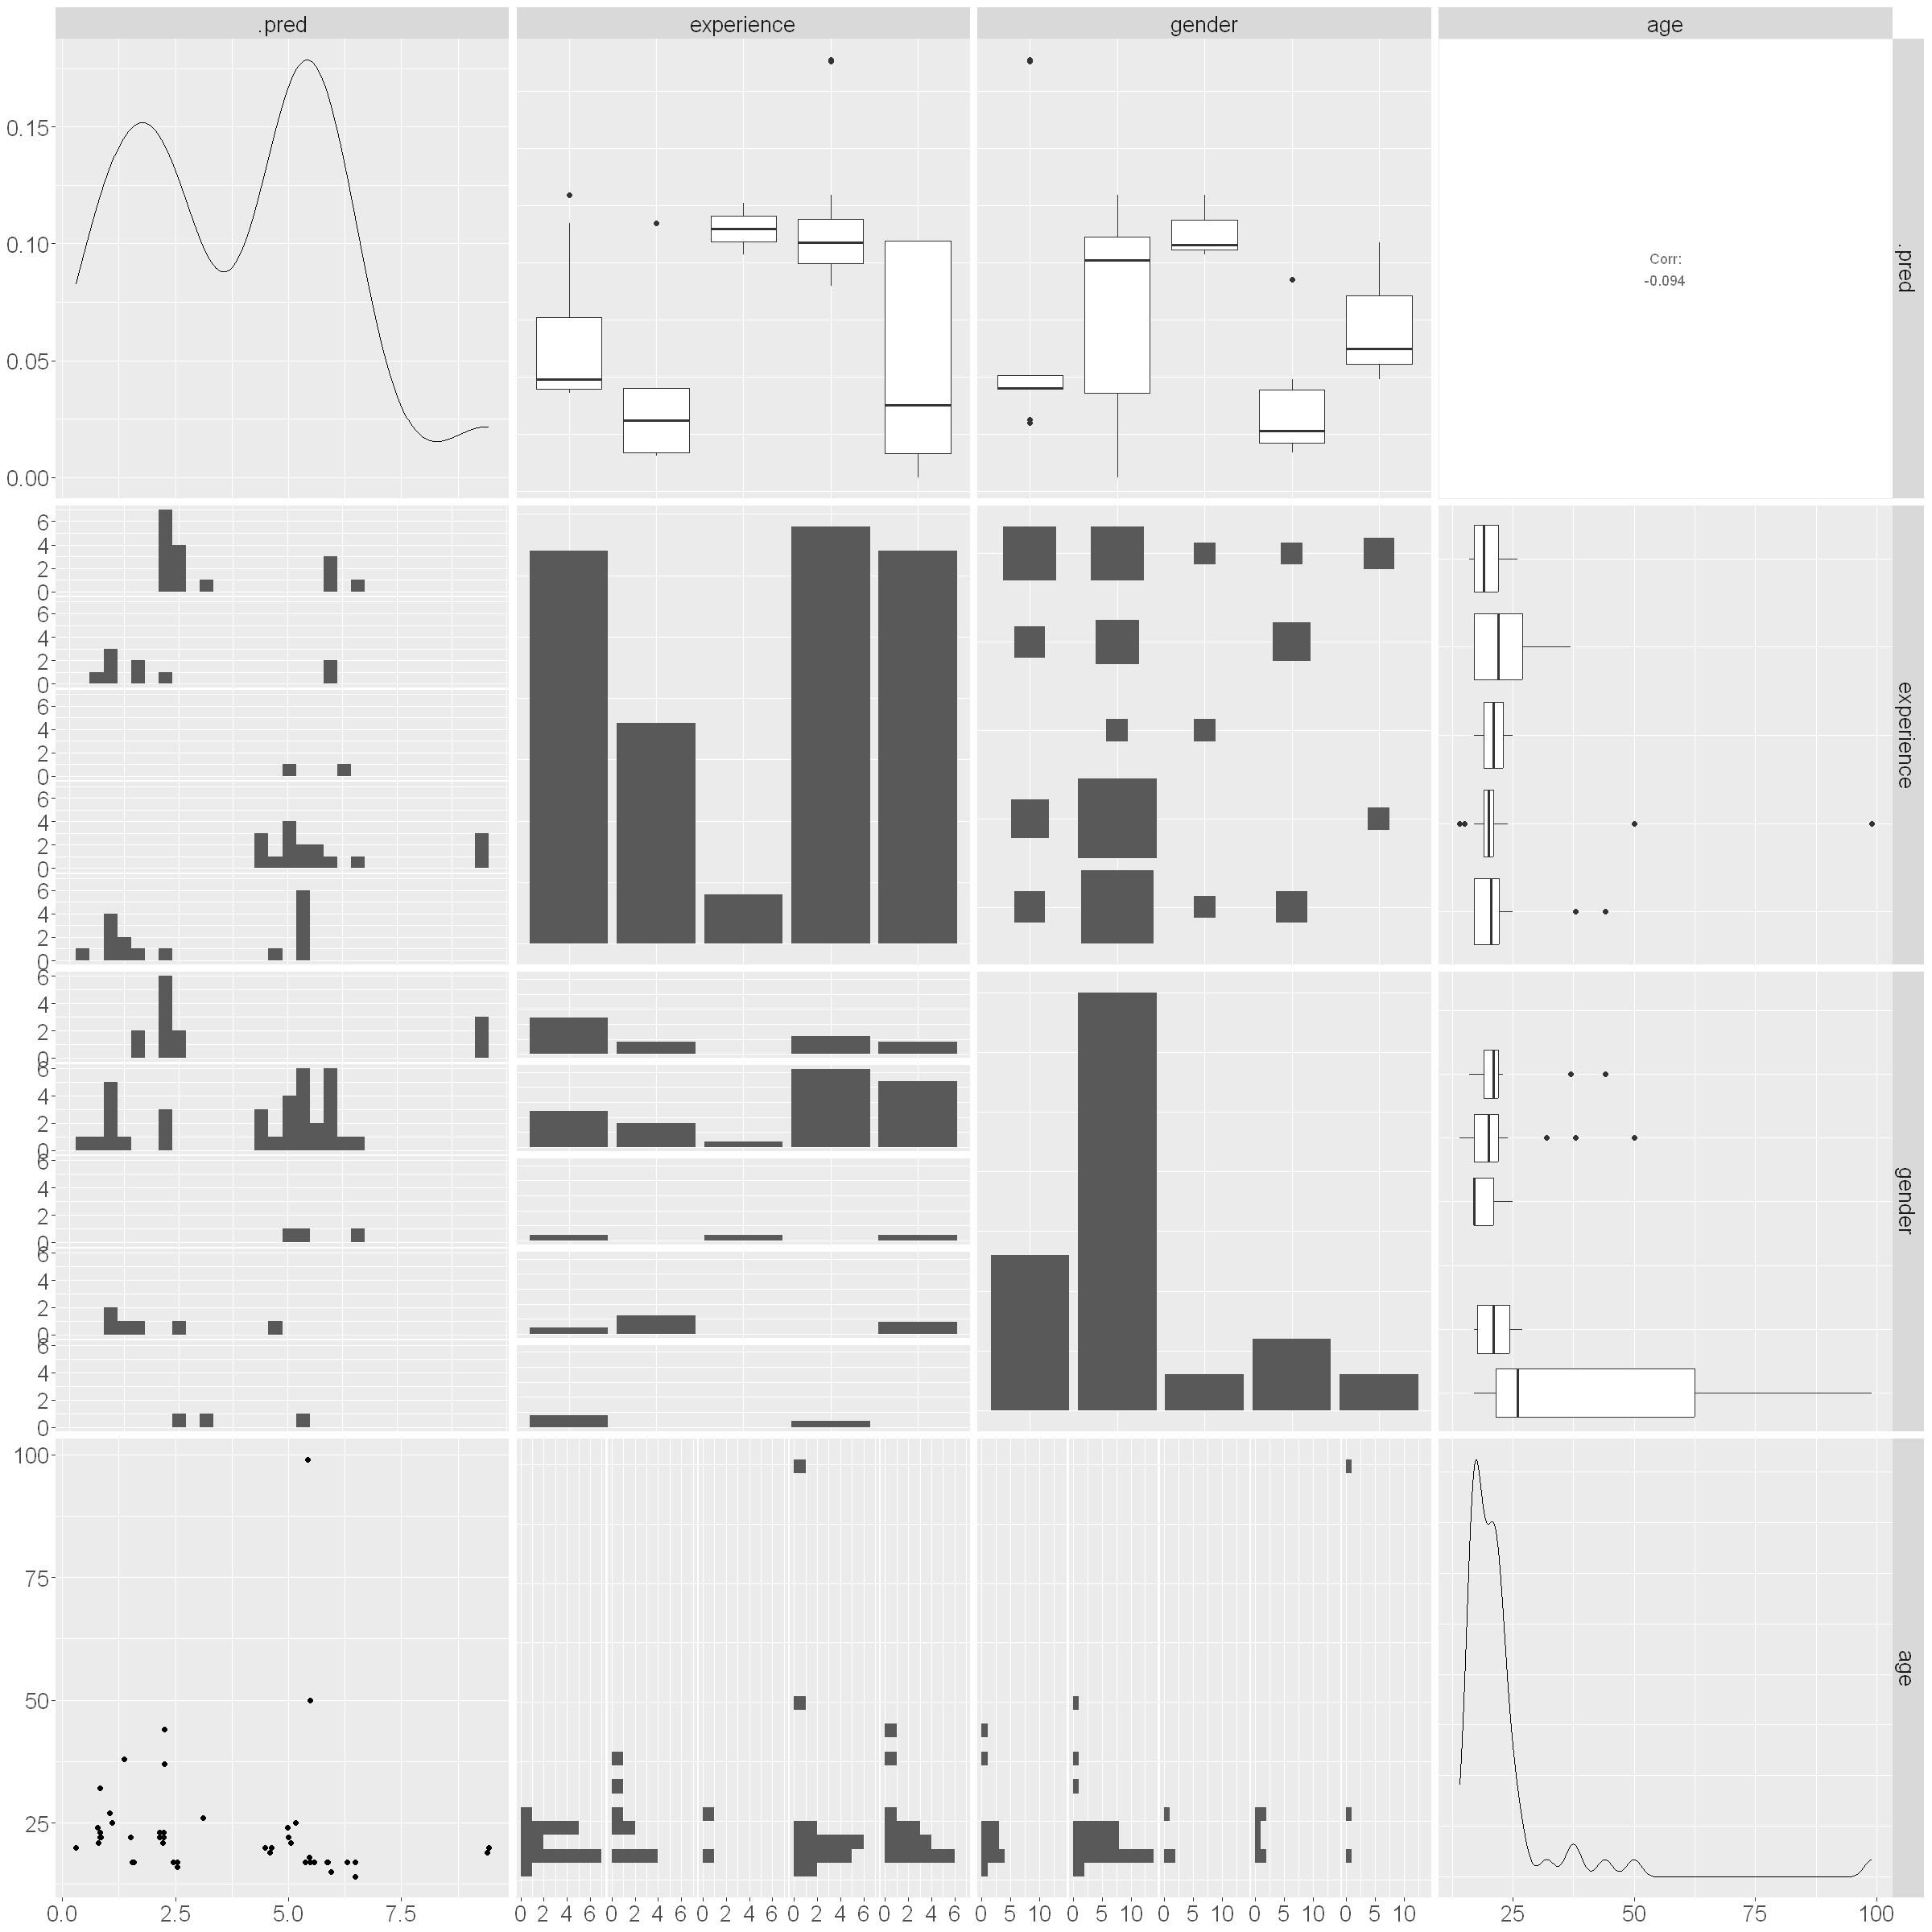

In [79]:
options(repr.plot.width = 20, repr.plot.height = 20)

# Plot using ggpairs with valid functions for categorical data
players_fit |>
    predict(players_test) |>
    bind_cols(players_test) |>
    select(-played_hours) |>
    ggpairs() +
    theme(text = element_text(size = 20))

## Discussion

## References (?)